In [1]:
import sys
import numpy as np
import argparse
from math import *

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\code\\myPy')  
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\CUDA\\RSgpu\\Release')
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
import ablation_utils
import geom
import sonalleve
import transducers
import PBHE_CUDA

import importlib

import matplotlib.image as image
import matplotlib.pyplot as plt

plt.rc('font', family='sans-serif', size=24)
%matplotlib inline

def L2norm(arg):
    return np.sqrt(np.sum(np.abs(arg)**2))

In [11]:
importlib.reload(ablation_utils)

<module 'ablation_utils' from 'C:\\Users\\Vandiver\\Documents\\HiFU\\code\\AblationSims\\ablation_utils.py'>

In [17]:
importlib.reload(transducers)

<module 'transducers' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\transducers.py'>

In [11]:
#parameters from Kohler
rho=1050
Cp=3500

c0=1540
f0=1.2e6
k0=f0*2*pi/c0
ktdiffusion=0.6


xw=3.0
yw=3.0
zmin=11.0
zmax=16.0

Nt=25
Nx=80
Ny=80
Nz=64

dataType = np.float32

simPhysGrid = ablation_utils.makeSimPhysGrid(nt=Nt,nx=Nx,ny=Ny,nz=Nz,rho=rho, ktherm=ktdiffusion, f0=f0,Cp=Cp,c0=c0,
    dt=0.1, xr=[-xw/2.0, xw/2.0], yr=[-yw/2.0, yw/2.0],zr=[zmin,zmax])

Rbase = np.zeros([Nx,Ny,Nz],dtype=dataType)
CEM0=np.zeros([Nx,Ny,Nz],dtype=dataType)
CEM1=np.zeros_like(CEM0)

[T,xrp,yrp,zrp]=[simPhysGrid[k] for k in tuple('T,xrp,yrp,zrp'.split(','))]
(dt,dx,dy,dz)=simPhysGrid['dtxyz']

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)

zplane=0.14
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<0) ))[0][0]


yci=floor(Ny/2)
xci=floor(Nx/2)

In [10]:
simPhysGrid['T'].shape

(25, 80, 64, 64)

In [12]:
ROION= geom.roiGen([[0.00,0.0, 0.14]], lambda x,y,z: geom.inEllipse(x,y,z, 0.01, 0.01,0.015),gxp,gyp,gzp)   

In [86]:
simPhysGrid.keys()

dict_keys(['Tdotmesh', 'zrp', 'T', 'rhoCpmesh', 'xrp', 'Tmesh', 'rhoCp', 'dtxyz', 'kt', 'Tdot', 'rho', 'yrp', 'kmesh', 'c0', 'k0'])

In [13]:
RSkeys=dict(subsampN=10, ROC=0.14, subsampDiam=0.0066, gpublocks=512)


uxyz = sonalleve.get_sonalleve_xdc_vecs()
unvec = sonalleve.get_sonalleve_xdc_normals()

calibFocus = [0.0,0.0,0.14]
calibAmp = transducers.get_focused_element_vals(simPhysGrid['k0'],uxyz,[calibFocus], [1] )

ds=np.arange(-0.005,0.005,0.0005)
pp0=transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, calibAmp , calibFocus[0]+ds, [calibFocus[1]], calibFocus[2]+ds, **RSkeys)
Ip0 = np.abs(pp0)**2 / (2.0*rho*c0)

Ispta0 = 1e7

calibrationGain = (Ispta0/np.max(Ip0))

L2powRenorm = sqrt(calibrationGain)*L2norm(calibAmp)



C:\Users\Vandiver\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [78]:
Ifpks=[]
rmm = [0.0,4,12,16]
gains = np.sqrt([1,1.09276,2.3738,5.3628])
for ri in range(0,4):
    r=rmm[ri]
    rfocus = [r*1e-3, 0, 0.14]
    radialAmp = transducers.get_focused_element_vals(simPhysGrid['k0'],uxyz, [rfocus], [1], L2renorm=gains[ri]*L2powRenorm )
    pr=transducers.calc_pressure_profile_cuda(simPhysGrid['k0'], uxyz, unvec,  radialAmp,[rfocus[0]], [rfocus[1]], [rfocus[2]], **RSkeys )
    Ifpks.append(np.abs(pr[0])**2/(2*rho*c0))
Ifpks=np.array(Ifpks)

In [79]:
Ifpks[0]/Ifpks[1:]

array([ 0.99999741,  1.00000115,  1.00000706])

#### Pre-computed intensities (update if maxR_mm changes)

In [57]:
#use the new routine options to get array settings for the trajectories from Kohler et al., 2009
maxR_mm = 12
(coords_mm, numTurns, numSonPerTurn) = ablation_utils.kohler_trajectories(maxR_mm, 140.0)

totSonications = np.sum(numSonPerTurn)

#single focus amplitudes
(times,trajAmps0)=ablation_utils.trajectorySettings([maxR_mm, 140.0], doRotation=False, use_kohler_traj=True, L2renorm=L2powRenorm, k0=k0, uxyz=uxyz )

totSonications = 1
(times,trajAmps0)=ablation_utils.trajectorySettings([np.array([[0,0,140.0]]), 120.0, 0], doRotation=False, is_path=True, L2renorm=L2powRenorm, k0=k0, uxyz=uxyz )


I0precomputed = np.zeros([totSonications,Nx,Ny,Nz])

for soni in range(0,totSonications):
    print('\r%d / %d' %(soni+1,totSonications), end=' ',flush=True)
    P0 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, trajAmps0[2*soni], xrp, yrp, zrp, **RSkeys )
    I0precomputed[soni][:] = np.abs(P0)**2 / (2*rho*c0)


1 / 1 

In [10]:
np.array([[0,0,140.0]]).shape

(1, 3)

In [80]:
numSonPerTurn

array([ 8, 16, 24])

In [63]:
trajSteerPower=[]
for soni in range(0,totSonications):
    trajSteerPower.append( np.sum( np.abs(trajAmps0[2*soni])**2) )
trajSteerPower=np.array(trajSteerPower)

In [64]:
trajSteerPower

array([  1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11,
         1.26389572e+11,   1.26389572e+11,   1.26389572e+11])

In [58]:
#multi-focus
pxyz,h = geom.ring(0.004,4,z=0)

(junk, trajAmps1)=ablation_utils.trajectorySettings([maxR_mm, 140.0], pxyz=pxyz, doRotation=False, use_kohler_traj=True, AlternatePhases=True, L2renorm=L2powRenorm, k0=k0, uxyz=uxyz )


#totSonications = 1
(times,trajAmps1)=ablation_utils.trajectorySettings([np.array([[0,0,140.0]]), 120.0, 0], doRotation=False, pxyz=pxyz,
                                                    is_path=True, AlternatePhases=True, L2renorm=L2powRenorm, k0=k0, uxyz=uxyz )


try:
    del I1precomputed
except NameError:
    pass

I1precomputed = np.zeros([totSonications,Nx,Ny,Nz])

for soni in range(0,totSonications): 
    print('\r%d / %d' %(soni+1,totSonications), end=' ',flush=True)
    P1 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, trajAmps1[2*soni], xrp, yrp, zrp, **RSkeys )
    I1precomputed[soni][:] = np.abs(P1)**2 / (2*rho*c0)

1 / 1 

In [112]:
np.max(I0precomputed,axis=(1,2,3))

array([ 7557729.77503304,  9111954.31626328,  7557729.77503304,
        9111954.31626325,  7557729.775033  ,  9111954.31626328,
        7557729.77503298,  9111954.31626331,  5900808.44900293,
        6520266.35492318,  5899342.81972755,  6520266.39178058,
        5900808.44900292,  6520266.35492311,  5899342.81972756,
        6520266.39178058,  5900808.44900303,  6520266.35492317,
        5899342.81972759,  6520266.39178057,  5900808.44900292,
        6520266.35492312,  5899342.81972756,  6520266.39178052,
        3419953.13526873,  3649850.70647752,  4121303.82778825,
        4068622.30896661,  4121303.46452917,  3649851.49833287,
        3419953.13526865,  3649850.70647749,  4121303.82778827,
        4068622.30896661,  4121303.46452919,  3649851.49833298,
        3419953.13526854,  3649850.70647738,  4121303.8277883 ,
        4068622.30896661,  4121303.4645292 ,  3649851.49833295,
        3419953.1352684 ,  3649850.70647728,  4121303.82778825,
        4068622.30896661,  4121303.46452

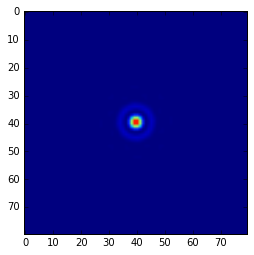

In [16]:
plt.imshow(np.sum(I0precomputed[:,:,:,focplaneZpix],axis=0),vmin=0.00001*Ispta0,vmax=Ispta0)

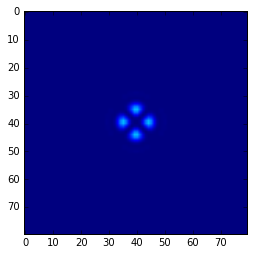

In [17]:
plt.imshow(np.sum(I1precomputed[:,:,:,focplaneZpix],axis=0),vmin=0.00001*Ispta0,vmax=Ispta0)

In [74]:
len(times)/2

48.5

In [76]:
times.shape

(97,)

### Heating

In [18]:
def timeEdgesVector(dwellSec, waitSec, Npass=1, storageVec=None, Npoints=0,tzero=0.0):
    """
    Return time edges, with each sonicaiton point including a dwell and a wait (possibly zero)
    """
    if storageVec is not None:
        Npoints = floor(len(storageVec)/2)*Npass
    else:
        storageVec = np.zeros(2*Npoints*Npass + 1)
        
    if Npoints <=0:
        return None

    storageVec[0]=tzero
    for ti in range(0,Npoints*Npass):
        storageVec[2*ti+1] = storageVec[2*ti] + dwellSec
        storageVec[2*ti+2] = storageVec[2*ti+1] + waitSec
        
    return storageVec

def heating(timeEdges, intensitySet, CEM, CEMinit=0,T0=37.0, alpha=1.0, Npass=1, PBdict={} ):

    T[0] = T0
    CEM[:]=CEMinit
    
    [Tdot, Tmesh, Tdotmesh, kmesh, rhoCpmesh, rhoCp]=[simPhysGrid[k] for k in tuple('Tdot,Tmesh,Tdotmesh,kmesh,rhoCpmesh,rhoCp'.split(','))]
    
    numSons = intensitySet.shape[0]

    for pi in range(0,Npass):
        for soni in range(0,numSons):
            
            ti = pi*numSons + soni
            print('\r%d / %d' %(ti+1,numSons*Npass), end=' ')
            
            duration = timeEdges[2*ti + 1] - timeEdges[2*ti]
            Tdot[:] = dataType(2.0*alpha*intensitySet[soni] / rhoCp)
            ablation_utils.calc_heating(simPhysGrid, T, Tdot, Tmesh, Tdotmesh, kmesh, rhoCpmesh, duration, CEM, Rbase, 
                                        GPU=False, interpoffset=timeEdges[2*ti], **PBdict)

            Tdot[:] = 0
            duration = timeEdges[2*ti + 2] - timeEdges[2*ti+1]
            ablation_utils.calc_heating(simPhysGrid, T, Tdot, Tmesh, Tdotmesh, kmesh, rhoCpmesh, duration, CEM, Rbase, 
                                        GPU=False, interpoffset=timeEdges[2*ti + 1], **PBdict)

    return duration


def heatInterpFunc(temp3d):
    tidx=heatInterpFunc.idx  
    #interpoDose[calcDosageIntegrands.idx] = np.max( temp2cem(temp3d) )
    CEMptr=heatInterpFunc.CEM
    ROION=heatInterpFunc.ROI 
    idx=heatInterpFunc.idx
    heatInterpFunc.out1[idx] = temp3d[:,:,focplaneZpix] 
    heatInterpFunc.out2[idx] = CEMptr[:,:,focplaneZpix]
    heatInterpFunc.out3[idx] = CEMptr[:,yci,:]
    
    heatInterpFunc.out4[idx] = temp3d[:,yci,:]
    heatInterpFunc.out5[idx] = np.max(temp3d[ROION])
    heatInterpFunc.vol240[idx] = np.sum( CEMptr>=240.0 )
    heatInterpFunc.vol240ON[idx] = np.sum( CEMptr[ROION]>=240.0 )
    
    return np.mean(temp3d)

heatInterpFunc.ROI=ROION


In [21]:
Npass=1 

#times=timeEdgesVector(4.0, 0.0, Npoints=totSonications, Npass=Npass);

In [59]:
interpTimes = np.arange(0.0, times[-1], 1.0)
Nnt=len(interpTimes)

Ntxy=[Nnt,Nx,Ny]
Ntxz=[Nnt,Nx,Nz]

interpTemp0=np.zeros(Nnt)
interpTemp1=np.zeros(Nnt)
(interpTempFocPlane0, interpCEMFocPlane0, interpCEMFocAxial0, interpTempAxial0, vol240_0, vol240ON_0, maxT0)=(
    np.zeros(Ntxy), np.zeros(Ntxy), np.zeros(Ntxz), np.zeros(Ntxz), np.zeros(Nnt), np.zeros(Nnt), np.zeros(Nnt) )
(interpTempFocPlane1, interpCEMFocPlane1, interpCEMFocAxial1, interpTempAxial1, vol240_1, vol240ON_1, maxT1)=(
    np.zeros(Ntxy), np.zeros(Ntxy), np.zeros(Ntxz), np.zeros(Ntxz), np.zeros(Nnt), np.zeros(Nnt), np.zeros(Nnt))

In [60]:


(heatInterpFunc.idx, heatInterpFunc.CEM, heatInterpFunc.vol240, heatInterpFunc.vol240ON) = (0, CEM1, vol240_1, vol240ON_1)
(heatInterpFunc.out1, heatInterpFunc.out2, heatInterpFunc.out3, heatInterpFunc.out4, heatInterpFunc.out5)=(
        interpTempFocPlane1,interpCEMFocPlane1,interpCEMFocAxial1,interpTempAxial1,maxT1)
#alpha=7.68
heating(times, I1precomputed, CEM1, alpha=2.0, Npass=Npass,  
        PBdict=dict(verbose=False,Freeflow=1,interpTimes=interpTimes, interpolatedTemp=interpTemp1, interpFunc=heatInterpFunc))

1 / 1 

0.0

In [61]:
(heatInterpFunc.idx, heatInterpFunc.CEM, heatInterpFunc.vol240, heatInterpFunc.vol240ON) = (0, CEM0, vol240_0, vol240ON_0)
(heatInterpFunc.out1, heatInterpFunc.out2, heatInterpFunc.out3, heatInterpFunc.out4, heatInterpFunc.out5)=(
        interpTempFocPlane0,interpCEMFocPlane0,interpCEMFocAxial0,interpTempAxial0,maxT0)

#alpha=7.68
heating(times, I0precomputed, CEM0, alpha=2.0,Npass=Npass, 
        PBdict=dict(verbose=False,Freeflow=1,interpTimes=interpTimes, interpolatedTemp=interpTemp0, interpFunc=heatInterpFunc))

1 / 1 

0.0

In [36]:
interpTempFocPlane1.shape

(30, 64, 64)

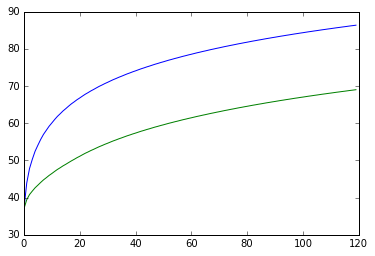

In [62]:
plt.plot( maxT0 )
plt.plot( maxT1 )

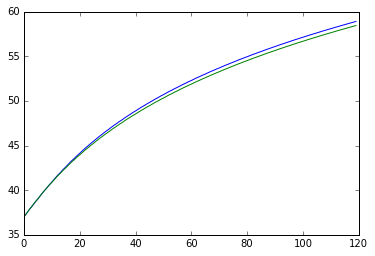

In [63]:

plt.plot( np.mean(interpTempFocPlane0[:,floor(Nx/2-10):floor(Nx/2+10),floor(Ny/2-10):floor(Ny/2+10)],axis=(1,2)) )
plt.plot( np.mean(interpTempFocPlane1[:,floor(Nx/2-10):floor(Nx/2+10),floor(Ny/2-10):floor(Ny/2+10)],axis=(1,2)) )

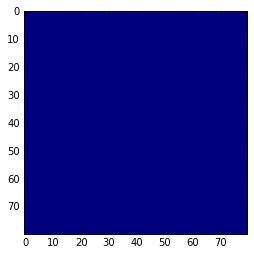

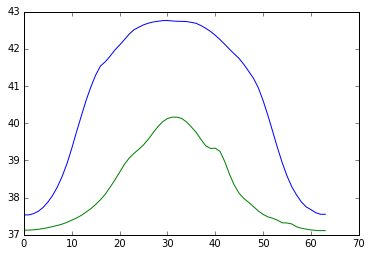

In [108]:
plt.plot(T[0][:,yci,focplaneZpix])
plt.plot(T[0][:,yci+20,focplaneZpix])

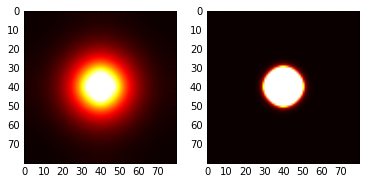

In [67]:
plt.subplot(121)
plt.imshow(np.max(interpTempFocPlane1,axis=0),vmin=37,vmax=60,cmap=image.cm.hot)
plt.subplot(122)
plt.imshow(CEM1[:,:,focplaneZpix],vmin=0,vmax=240,cmap=image.cm.hot)

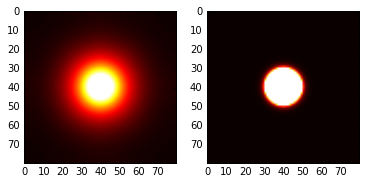

In [65]:
plt.subplot(121)
plt.imshow(np.max(interpTempFocPlane0,axis=0),vmin=37,vmax=60,cmap=image.cm.hot)
plt.subplot(122)
plt.imshow(CEM0[:,:,focplaneZpix],vmin=0,vmax=240,cmap=image.cm.hot)

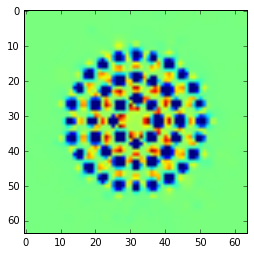

In [203]:
plt.imshow(np.max(interpTempFocPlane1,axis=0) - np.max(interpTempFocPlane0,axis=0),vmin=-10,vmax=10,cmap=image.cm.jet)


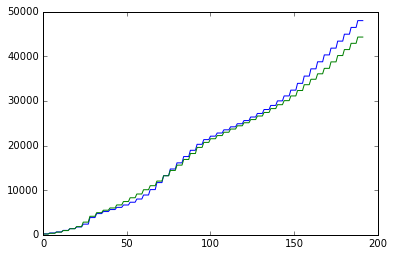

In [178]:
plt.plot(interpTimes,vol240_0)
plt.plot(interpTimes,vol240_1)

In [148]:
#Np=8, dw=0.5
vol240_fast0 = vol240_0.copy()
vol240_fast1 = vol240_1.copy()

In [161]:
#Np=4, dw=1
vol240_med0 = vol240_0.copy()
vol240_med1 = vol240_1.copy()

In [169]:
#Np=2, dw=2
vol240_np2_0 = vol240_0.copy()
vol240_np2_1 = vol240_1.copy()

In [ ]:
dx

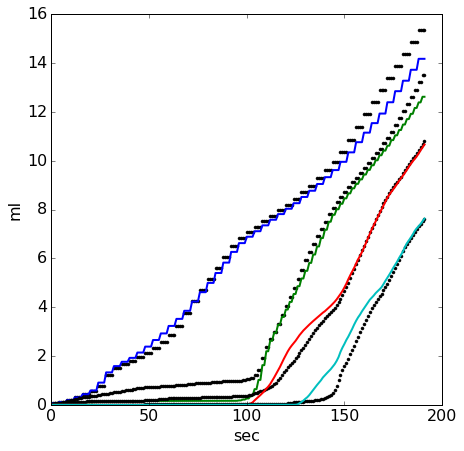

In [216]:
plt.figure(figsize=(7,7))

voxml=dx*dy*dz*1e6

plt.plot(interpTimes,vol240_0*voxml,'k.')
plt.plot(interpTimes,vol240_1*voxml,linewidth=2.0)

plt.plot(interpTimes,vol240_np2_0*voxml,'k.')
plt.plot(interpTimes,vol240_np2_1*voxml,linewidth=2.0)

plt.plot(interpTimes,vol240_med0*voxml,'k.')
plt.plot(interpTimes,vol240_med1*voxml,linewidth=2.0)

plt.plot(interpTimes,vol240_fast0*voxml,'k.')
plt.plot(interpTimes,vol240_fast1*voxml,linewidth=2.0)

plt.xlabel('sec',fontsize=16)
plt.ylabel('ml',fontsize=16)
plt.gca().tick_params(labelsize=16)

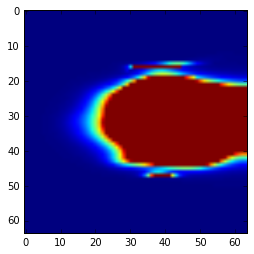

In [213]:
plt.imshow( interpCEMFocAxial1[80],vmin=0,vmax=240)

In [198]:
interpCEMFocAxial1.shape

(192, 64, 64)

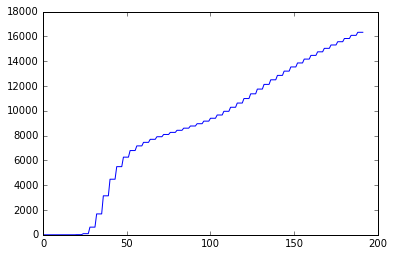

In [218]:
plt.plot(interpCEMFocAxial1[:,xci,focplaneZpix])

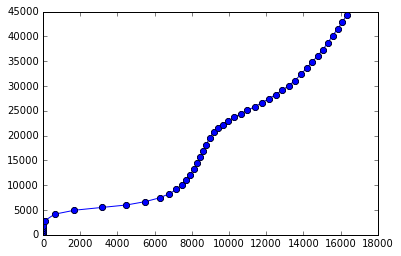

In [221]:
plt.plot(interpCEMFocAxial1[:,xci,focplaneZpix], vol240_1,'-o')